# ODC Conference African Waterbodies Sprint Notebook

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/products/ga_ls8c_wofs_2), 
[ga_ls8c_wofs_2_annual_summary](https://explorer.digitalearth.africa/products/ga_ls8c_wofs_2_annual_summary),
[ga_ls8c_wofs_2_summary](https://explorer.digitalearth.africa/products/ga_ls8c_wofs_2_summary),
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)

* **Prerequisites:** Check out Datasets/Water_Observations_from_Space.ipynb for info on reading in and working with the WOfS data


## Background
The plan for this sprint/hackaton is to test if the Tethys tool which was developed in Google Earth Engine will work in the ODC environment, using the Digital Earth Africa products.

See the following links for information:
   * https://tethys.servirglobal.net/apps/waterwatch/
   * https://docs.google.com/document/d/1LhinmRkqWNaHXniyXXf61gZuooEMcDORZioYUMNr6h4/edit
   * https://www.ga.gov.au/dea/products/dea-waterbodies


## Description
This notebook is a starting point for collaboration between Digital Earth Africa and the Tethys program for mapping small waterbodies in Africa.

1. First we look at using the existing WOfS product based on Landsat, and use the all time summary to find areas with water certain percentages of the time.
2. Then we look at how to run the WOfS algorithm on S2 data for a small area.


***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map, rgb

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='odc-waterbodies')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Using the WOfS summary

1) Start by reading in the wofs all time summary, will start with a region in Senegal to compare the WOfS and the Tethys.

2) Tethys has 3 bins: <25%, 25%-75% and >75%, since the WOfS summary gives a frequency percentage, this should be a straightforward comparison.

In [3]:
#location
#top left: 15.75575°N, 13.37362°W
#bottom right: 15.65709°N, 13.21707°W

#change the location and buffer if you want to try another region
lat, lon = 15.70, -13.29
lat_buffer, lon_buffer = 0.1, 0.1

In [4]:
#check the location on a map
display_map((lon-lon_buffer, lon+lon_buffer),(lat-lat_buffer, lat+lat_buffer))

In [5]:
#Set up a query
query = {
    'x': (lon-lon_buffer, lon+lon_buffer),
    'y': (lat+lat_buffer, lat-lat_buffer),
    'output_crs':'EPSG:6933',
    'resolution': (-30, 30)
}

In [6]:
#load them in - you can use another product if you like. 
#If you do, you can put eg time=2020 or time=2020-03-21 if you want one day
all_time_wofs = dc.load(product= 'ga_ls8c_wofs_2_summary',
                **query)

In [7]:
all_time_wofs

<xarray.Dataset>
Dimensions:      (time: 1, x: 645, y: 821)
Coordinates:
  * time         (time) datetime64[ns] 2016-07-01T23:59:59.999500
  * y            (y) float64 1.991e+06 1.991e+06 ... 1.966e+06 1.966e+06
  * x            (x) float64 -1.292e+06 -1.292e+06 ... -1.273e+06 -1.273e+06
    spatial_ref  int32 6933
Data variables:
    count_wet    (time, y, x) int16 0 1 1 2 1 4 1 2 3 1 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 107 107 107 107 109 ... 107 107 107 108 108
    frequency    (time, y, x) float32 0.0 0.009345794 0.009345794 ... 0.0 0.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

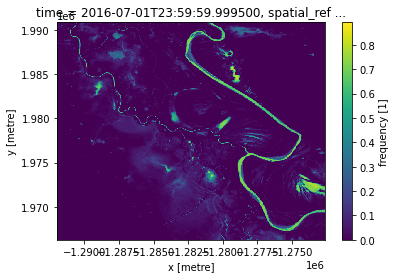

In [8]:
#See what this looks like as an image
all_time_wofs['frequency'].plot()

### Separating into bins

In [9]:
#Split it into bins
less_25 = ((all_time_wofs['frequency'] <0.25) & (all_time_wofs['frequency'] >0.01))

In [10]:
less_25

<xarray.DataArray 'frequency' (time: 1, y: 821, x: 645)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2016-07-01T23:59:59.999500
  * y            (y) float64 1.991e+06 1.991e+06 ... 1.966e+06 1.966e+06
  * x            (x) float64 -1.292e+06 -1.292e+06 ... -1.273e+06 -1.273e+06
    spatial_ref  int32 6933

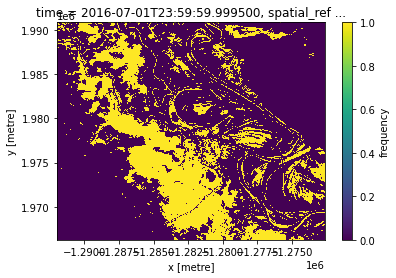

In [11]:
#plot the areas that are wet <25% of the time
less_25.plot()

In [12]:
#Split it into bins
between = ((all_time_wofs['frequency'] <=0.75) & (all_time_wofs['frequency'] >=0.25))
between

<xarray.DataArray 'frequency' (time: 1, y: 821, x: 645)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2016-07-01T23:59:59.999500
  * y            (y) float64 1.991e+06 1.991e+06 ... 1.966e+06 1.966e+06
  * x            (x) float64 -1.292e+06 -1.292e+06 ... -1.273e+06 -1.273e+06
    spatial_ref  int32 6933

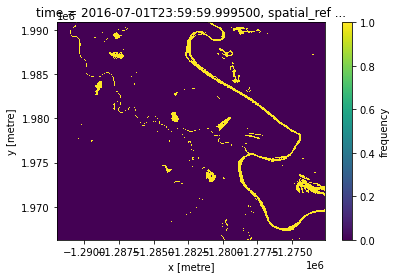

In [13]:
#plot the areas that are wet 25-75% of the time
between.plot()

In [14]:
#Split it into bins
greater_75 = (all_time_wofs['frequency'] >0.75) 
greater_75

<xarray.DataArray 'frequency' (time: 1, y: 821, x: 645)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2016-07-01T23:59:59.999500
  * y            (y) float64 1.991e+06 1.991e+06 ... 1.966e+06 1.966e+06
  * x            (x) float64 -1.292e+06 -1.292e+06 ... -1.273e+06 -1.273e+06
    spatial_ref  int32 6933

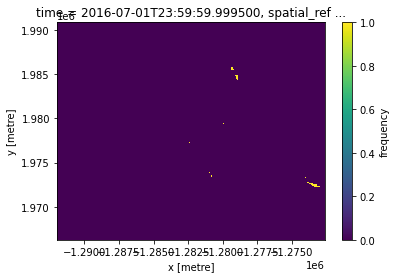

In [15]:
#plot the areas that are wet >75% of the time
greater_75.plot()

# Using Sentinel 2 to produce WOfS

Here we will create a water observation feature layer (WOFL) for a certain region using S2 data.

start by setting location and making a query

In [16]:
#change the location and buffer if you want to try another region
lat, lon = 15.70, -13.29
lat_buffer, lon_buffer = 0.1, 0.1

In [17]:
#check the location on a map
display_map((lon-lon_buffer, lon+lon_buffer),(lat-lat_buffer, lat+lat_buffer))

In [18]:
# the s2 bands we'll need
bands = ['nir', 'red', 'green', 'blue', 'swir_1', 'swir_2', 'qa']

In [19]:
#Set up a query
query = {
    'x': (lon-lon_buffer, lon+lon_buffer),
    'y': (lat+lat_buffer, lat-lat_buffer),
    'output_crs':'EPSG:6933',
    'resolution': (-10, 10)
}

In [ ]:
s2_in = dc.load(product= 's2_l2a',
                measurements = bands,
                time = '2020-01',
                **query)

In [ ]:
s2_in

In [ ]:
# this function is to run wofs DO NOT CHANGE :) 
import gc
import numpy as np
import xarray as xr

import datacube
# Command line tool imports
import argparse
import os
import collections
import gdal
from datetime import datetime


def wofs_classify(dataset_in, clean_mask=None, x_coord='longitude', y_coord='latitude',
                  time_coord='time', no_data=-9999, mosaic=False, enforce_float64=False): 
    """
    Description:
      Performs WOfS algorithm on given dataset.
    Assumption:
      - The WOfS algorithm is defined for Landsat 5/Landsat 7
    References:
      - Mueller, et al. (2015) "Water observations from space: Mapping surface water from
        25 years of Landsat imagery across Australia." Remote Sensing of Environment.
      - https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py
    -----
    Inputs:
      dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube; should contain
        coordinates: time, latitude, longitude
        variables: blue, green, red, nir, swir1, swir2
    x_coord, y_coord, time_coord: (str) - Names of DataArrays in `dataset_in` to use as x, y,
        and time coordinates.
    Optional Inputs:
      clean_mask (nd numpy array with dtype boolean) - true for values user considers clean;
        if user does not provide a clean mask, all values will be considered clean
      no_data (int/float) - no data pixel value; default: -9999
      mosaic (boolean) - flag to indicate if dataset_in is a mosaic. If mosaic = False, dataset_in
        should have a time coordinate and wofs will run over each time slice; otherwise, dataset_in
        should not have a time coordinate and wofs will run over the single mosaicked image
      enforce_float64 (boolean) - flag to indicate whether or not to enforce float64 calculations;
        will use float32 if false
    Output:
      dataset_out (xarray.DataArray) - wofs water classification results: 0 - not water; 1 - water
    Throws:
        ValueError - if dataset_in is an empty xarray.Dataset.
    """

    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Regression analysis based on Australia's training data
        TODO: Return type
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified

    # Default to masking nothing.
    if clean_mask is None:
        clean_mask = create_default_clean_mask(dataset_in)
    
    # Extract dataset bands needed for calculations
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir_1
    swir2 = dataset_in.swir_2

    # Enforce float calculations - float64 if user specified, otherwise float32 will do
    dtype = blue.values.dtype  # This assumes all dataset bands will have
    # the same dtype (should be a reasonable
    # assumption)

    if enforce_float64:
        if dtype != 'float64':
            blue.values = blue.values.astype('float64')
            green.values = green.values.astype('float64')
            red.values = red.values.astype('float64')
            nir.values = nir.values.astype('float64')
            swir1.values = swir1.values.astype('float64')
            swir2.values = swir2.values.astype('float64')
    else:
        if dtype == 'float64':
            pass
        elif dtype != 'float32':
            blue.values = blue.values.astype('float32')
            green.values = green.values.astype('float32')
            red.values = red.values.astype('float32')
            nir.values = nir.values.astype('float32')
            swir1.values = swir1.values.astype('float32')
            swir2.values = swir2.values.astype('float32')

    shape = blue.values.shape
    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean = np.full(classified.shape, no_data, dtype='float64')
    classified_clean[clean_mask] = classified[clean_mask]  # Contains data for clear pixels

    # Create xarray of data
    x_coords = dataset_in[x_coord]
    y_coords = dataset_in[y_coord]

    time = None
    coords = None
    dims = None

    if mosaic:
        coords = [y_coords, x_coords]
        dims = [y_coord, x_coord]
    else:
        time_coords = dataset_in[time_coord]
        coords = [time_coords, y_coords, x_coords]
        dims = [time_coord, y_coord, x_coord]

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    if mosaic:
        dataset_out = xr.Dataset({'wofs': data_array},
                                 coords={y_coord: y_coords, x_coord: x_coords})
    else:
        dataset_out = xr.Dataset(
            {'wofs': data_array},
            coords={time_coord: time_coords, y_coord: y_coords, x_coord: x_coords})

    return dataset_out

In [ ]:
# these are for single dates, so you just get a wet/dry answer
clean_mask = np.isin(s2_in['qa'], [4,5,6,7,11])
s2_wofs = wofs_classify(s2_in, 
                      clean_mask=clean_mask, 
                      no_data=np.nan, 
                      x_coord='x', 
                      y_coord='y')

In [ ]:
s2_wofs

In [ ]:
# some are bad because of l
s2_wofs['wofs'][7].plot()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')